# AIcadium Data Science Challenge

# 1. Imports and Data Loading

We import the data from Github, inspect it, and check for missing values. Fortunately, there are no missing values in this dataset.

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import warnings
pd.set_option("display.max_columns", 101)
rng = np.random.default_rng(1)

In [9]:
#Ingesting the data
url = 'https://raw.githubusercontent.com/HansonQin/AIcadium_Project/main/coding_round_data.csv'
df = pd.read_csv(url)

(12330, 18)

In [138]:
df.head(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,0


In [11]:
df.shape

(12330, 18)

In [12]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [13]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [16]:
#Seeing the number of missing values for each column
print(" \nCount total NaN at each column in a DataFrame : \n", df.isnull().sum())

 
Count total NaN at each column in a DataFrame : 
 Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64


Note that this dataset has no missing values.

# 2. Data Splitting and Transforming

We now split this dataset into training, validation, and test sets. Furthermore, we standardize the numeric columns to have a mean of 0 and a variance of 1. We also use one hot encoding to transform the categorical variables, while dropping the first category of each variable to ensure linear independence in our dataset.

In [30]:
#Changing "revenue" column to a binary column
df["Revenue"] = df["Revenue"].astype(int)

In [31]:
#Transforming the categorical variables through one hot encoding
categorical_cols = ['Month','OperatingSystems','Browser','Region','TrafficType','VisitorType','Weekend']
numeric_cols = ['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration','BounceRates','ExitRates','PageValues','SpecialDay']
ohe = OneHotEncoder(sparse=False,drop='first')
oh_data = ohe.fit_transform(df[categorical_cols])
oh_data = pd.DataFrame(oh_data, columns=ohe.get_feature_names())
 

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [92]:
#Splitting the training data into train/test set with a 80/20 split
train_rows = rng.choice(len(df), size = int(len(df)*0.8),replace=False) 
test_rows = list(set(range(len(df)))-set(train_rows))
#Transforming the numeric variables through standardization
ss = StandardScaler()
ss.fit(df.iloc[train_rows][numeric_cols])
numeric_standardized = pd.DataFrame(ss.transform(df[numeric_cols]),columns=numeric_cols)
X = pd.concat([numeric_standardized,oh_data],axis = 1)
X_train, X_test = X.iloc[train_rows],X.iloc[test_rows]
y_train,y_test = df['Revenue'].iloc[train_rows],df['Revenue'].iloc[test_rows]

#Further splitting for training/validation
X_train_val, X_val = X.iloc[train_rows[:int(len(train_rows)*0.8)]],X.iloc[train_rows[int(len(train_rows)*0.8):]]
y_train_val, y_val = df['Revenue'].iloc[train_rows[:int(len(train_rows)*0.8)]],df['Revenue'].iloc[train_rows[int(len(train_rows)*0.8):]]


# 3. Modeling, Machine Learning

The dataset is pretty simple with only 17 features. Due to the low feature count and that none of the features are obviously independent from Revenue (no ID columns for instance), we will not be dropping any features. We will be exploring 3 models - logistic regression, SVM, and gradient boosting tree.

Logistic Regression is a nice model to use since it is simple and easily interpretable. However, logistic regression makes a lot of assumptions about the data, primarily that the predictive features are independent of each other on their effect on the response variable, which I may not believe to be safe to assume. We will be using SVM and GBT to avoid having to do feature crossing or regularization. SVM and GBT also tend to perform very well on binary classification. For the GBT model, we will be choosing its number of estimators through cross validation.

For model comparison, we will be using the average precision score due to the imbalance of the revenue column (~85% False, ~15% True). Also, for the final model, we will change its probability threshold from the default 0.5 to a value that maximizes [True Positive Rate * (1 - False Positive Rate)] using the validation set.

We see that GBT preformed the best on the test set with a 85% accuracy, but considering that we can get a similar accuracy by predicting all 0s, this isn't particularly good. The F1 score, which is better for imbalanced datasets, confirms this.


In [46]:
test = X_test.copy()

In [127]:
# Logistic Regression
lr = LogisticRegression(solver='newton-cg').fit(X_train, y_train)
lr_test = lr.predict_proba(X_test)[:,1]
print("Logistic Regression Average Precision Score:",average_precision_score(y_test,lr_test))

Logistic Regression Average Precision Score: 0.6548335664856125


In [116]:
#SVM
clf = svm.SVC(probability=True).fit(X_train,y_train)
print("SVM Accuracy Score:",clf.score(X_test, y_test))
svm_test = clf.predict_proba(X_test)[:,1]
print("SVM Average Precision Score:",average_precision_score(y_test,svm_test))

SVM Accuracy Score: 0.9059205190592052
SVM Average Precision Score: 0.6905922022322356


In [121]:
#Gradient Boosting Tree
xg = xgb.XGBClassifier(verbosity = 0).fit(X_train,y_train)
xg_test = xg.predict_proba(X_test)[:,1]
print("GBT Accuracy Score:",xg.score(X_test, y_test))
print("GBT Average Precision Score:",average_precision_score(y_test,xg_test))

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


GBT Accuracy Score: 0.9051094890510949
GBT Average Precision Score: 0.7145897587255217


In [113]:
#Cross validation to determine number of estimators for GBT
gbt_cv = []
for i in range(1,len(X_train.columns)+1):
    xg = xgb.XGBClassifier(n_estimators=i,verbosity = 0,use_label_encoder=False).fit(X_train,y_train) 
    gbt_cv.append(cross_val_score(xg,X_train, y_train, cv=5).mean())

In [114]:
#Our CV Optimal number of estimators
np.argmax(np.array(gbt_cv)) + 1

5

In [123]:
xg = xgb.XGBClassifier(n_estimators=5,verbosity = 0).fit(X_train_val,y_train_val)
xg_val = xg.predict_proba(X_val)[:,1]

In [124]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(y_val, xg_val)
roc_auc = auc(fpr, tpr)

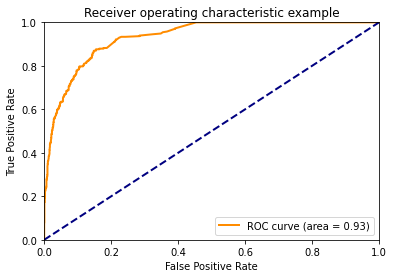

In [125]:
#Plotting the LR ROC Curve
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [126]:
#Computing the best threshold
gmeans = tpr * (1-fpr)
id = np.argmax(gmeans)
thresholds[id]

0.20534597

In [128]:
#Evaluating GBT with updated Threshold on entire training set
xg = xgb.XGBClassifier(n_estimators=5,verbosity = 0).fit(X_train,y_train)
xg_test = (xg.predict_proba(X_test)[:,1] >= thresholds[id]).astype(int)
print("GBT Accuracy:", accuracy_score(y_test,xg_test))
print("GBT F1 Score:", f1_score(y_test,xg_test))

Logistic Regression Accuracy: 0.8503649635036497
Logistic Regression F1 Score: 0.6306306306306306


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


# 4. Visualization

We inspect the feature importance for our GBT model using the SHAP graph. We see that the first few entries make sense, saying that high PageValues (avg. number of visits to a web page before purchase), November visits, and high Product Related page visits positively correlates with Revenue.

We also inspect the Regression summary for a logistic regression model trained on the entire dataset. Looking at the z-statistics, it looks like the significant columns are Returning Visitor, the Month of visit, ExitRates and Page Value.

In [137]:
oh_data.head(1)

,x0_Dec,x0_Feb,x0_Jul,x0_June,x0_Mar,x0_May,x0_Nov,x0_Oct,x0_Sep,x1_2,x1_3,x1_4,x1_5,x1_6,x1_7,x1_8,x2_2,x2_3,x2_4,x2_5,x2_6,x2_7,x2_8,x2_9,x2_10,x2_11,x2_12,x2_13,x3_2,x3_3,x3_4,x3_5,x3_6,x3_7,x3_8,x3_9,x4_2,x4_3,x4_4,x4_5,x4_6,x4_7,x4_8,x4_9,x4_10,x4_11,x4_12,x4_13,x4_14,x4_15,x4_16,x4_17,x4_18,x4_19,x4_20,x5_Other,x5_Returning_Visitor,x6_True
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


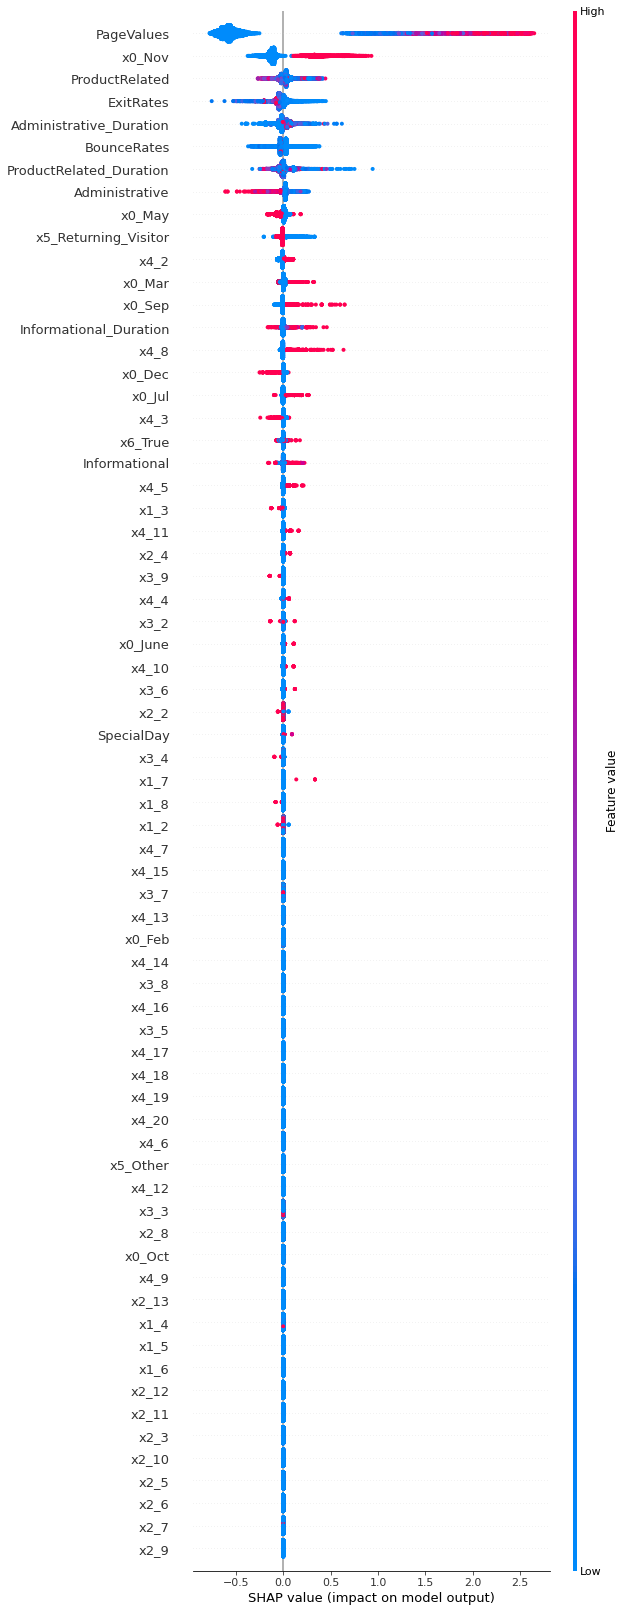

In [135]:
#SHAP
explainer = shap.Explainer(xg)
sv = explainer(X_train) 
shap.plots.beeswarm(sv, max_display=None)

In [143]:
import statsmodels.api as sm
log_reg_mult = sm.Logit(df['Revenue'], X).fit_regularized()
print(log_reg_mult.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2907474909968144
            Iterations: 523
            Function evaluations: 523
            Gradient evaluations: 523
                           Logit Regression Results                           
Dep. Variable:                Revenue   No. Observations:                12330
Model:                          Logit   Df Residuals:                    12262
Method:                           MLE   Df Model:                           67
Date:                Sun, 06 Mar 2022   Pseudo R-squ.:                  0.3252
Time:                        23:33:10   Log-Likelihood:                -3584.9
converged:                       True   LL-Null:                       -5312.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------